<a href="https://colab.research.google.com/github/yannidd/ai-society-lstm-lecture/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up libraries

In [1]:
# Select TensorFlow 2.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking

In [0]:
font = {'size': 14}
matplotlib.rc('font', **font)

## Data

### Load

In [7]:
accel_data = np.genfromtxt('https://raw.githubusercontent.com/yannidd/ai-society-lstm-lecture/master/data.csv', delimiter=',')
print(f'Acceleration data shape: {accel_data.shape}.\n'
      f'First 3 columns are acceleration data (x, y, z).\n'
      f'Last column is the label.')

Acceleration data shape: (107362, 4).
First 3 columns are acceleration data (x, y, z).
Last column is the label.


### Visualise

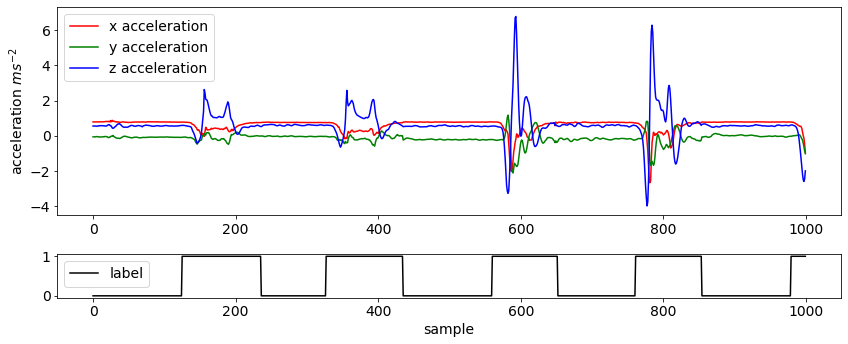

In [12]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot2grid((4, 1), (0, 0), 3, 1)
ax1 = plt.subplot2grid((4, 1), (3, 0), 1, 1)

ax0.plot(accel_data[:1000, 0], 'r')
ax0.plot(accel_data[:1000, 1], 'g')
ax0.plot(accel_data[:1000, 2], 'b')
ax1.plot(accel_data[:1000, 3], 'k')

ax0.set_ylabel(r'acceleration $ms^{-2}$')
ax1.set_xlabel('sample')

ax0.legend(['x acceleration','y acceleration','z acceleration'], loc=2)
ax1.legend(['label'], loc=2)

plt.tight_layout()
plt.show()

### Prepare for training

In [16]:
x = accel_data[:, :2][:, np.newaxis, :]
y = to_categorical(accel_data[:, 3], num_classes=2, dtype='float32')
print(f'x shape: {x.shape}\n'
      f'y shape: {y.shape}')

x shape: (107362, 1, 2)
y shape: (107362, 2)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    shuffle=False)
print(f'x_train shape: {x_train.shape}\n'
      f'x_test shape:  {x_test.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'y_test shape:  {y_test.shape}')

x_train shape: (75153, 1, 2)
x_test shape:  (32209, 1, 2)
y_train shape: (75153, 2)
y_test shape:  (32209, 2)


## Training

In [0]:
def make_model(name, stateful: bool=False):
   model = Sequential(name=name)

   if not stateful:
      model.add(LSTM(
         64,
         activation='tanh', 
         input_shape=(None, 3),
         unit_forget_bias=True, 
         return_sequences=True,
         stateful=stateful))
   else:
      model.add(LSTM(
         64,
         activation='tanh', 
         input_shape=(None, 3), 
         batch_input_shape=(1, None, 3),
         unit_forget_bias=True, 
         return_sequences=True,
         stateful=stateful))
   model.add(LSTM(
      32, 
      activation='tanh', 
      unit_forget_bias=True,
      stateful=stateful))
   model.add(Dense(
      16, 
      activation='relu'))
   model.add(Dense(
      2, 
      activation='softmax', 
      name='output_layer'))

   for layer in model.layers:
      layer.regularizers = regularizers.l2(l=0.0015)

   return model